In [1]:
import pandas as pd
from modules.fetcher import Fetcher
import matplotlib.pyplot as plt

fetcher = Fetcher()

In [2]:
now = pd.Timestamp.now().tz_localize(None)
start = pd.Timestamp('2023-05-01 00:00:00').tz_localize(None)

leverages = [1, 2, 5, 10]
fee = 0.001
penalty = 0.01
maintenance_margin = 0.05 # 5%
stop_loss_margin = maintenance_margin * (1 + 0.25)

In [3]:
def get_backtest_result(input_df, l):
    df = input_df.copy()
    for index, row in enumerate(df.iterrows()):
        if index == 0:
            df['clt'] = 1
            df['leverage'] = l
            df['entry'] = 0
            df['pos_size'] = 0
            df['change'] = 0
            df['change_pnl'] = 0
            df['funding'] = 0
            df['funding_pnl'] = 0
            df['margin'] = 0

            df['mm'] = df['clt'] * df['leverage'] * maintenance_margin
            df['mm_sl'] = df['clt'] * df['leverage'] * stop_loss_margin

            df['is_liq'] = False
            df['is_sl'] = False

            df['fee'] = -fee * df['leverage']
            df['penalty'] = 0
            df['final_pnl'] = 0
        else:
            prev_df = df.loc[index - 1]
            # check if is there was a trade in the previous record
            traded = prev_df['fee'] != 0

            # calculate new clt from previous clt + fee + penalty + funding pnl (if traded)
            new_clt = prev_df['clt'] + prev_df['fee'] + prev_df['penalty'] + (prev_df['funding_pnl'] if traded else 0)

            if new_clt == 0:
                df.loc[index, 'clt'] = 0
                df.loc[index, 'entry'] = 0
                df.loc[index, 'pos_size'] = 0
                df.loc[index, 'change'] = 0
                df.loc[index, 'change_pnl'] = 0
                df.loc[index, 'funding'] = 0
                df.loc[index, 'funding_pnl'] = 0
                df.loc[index, 'margin'] = 0
                df.loc[index, 'mm'] = 0
                df.loc[index, 'mm_sl'] = 0
                df.loc[index, 'is_liq'] = False
                df.loc[index, 'is_sl'] = False
                df.loc[index, 'fee'] = 0
                df.loc[index, 'penalty'] = 0
                df.loc[index, 'final_pnl'] = -1
            else:
                price = float(df.loc[index, 'close'])
                funding_rate = float(df.loc[index, 'funding_rate'])

                df.loc[index, 'clt'] = max(new_clt, 0)
                # Entry price of the current position
                df.loc[index, 'entry'] = price if traded else prev_df['entry']
                # Size of the current position
                df.loc[index, 'pos_size'] = price * df.loc[index, 'clt'] * df.loc[index, 'leverage']
                # Change of the current position (compared to entry price)
                df.loc[index, 'change'] = (price - df.loc[index, 'entry']) / df.loc[index, 'entry'] if df.loc[index, 'entry'] != 0 else 0
                # Change pnl (we treat any changes as loss since we will either close the short position or long position if the price hits the stop loss)
                df.loc[index, 'change_pnl'] = -abs(df.loc[index, 'change'] * df.loc[index, 'leverage'])
                # Funding payment comes from the funding rate and the position size (collateral + change pnl)
                df.loc[index, 'funding'] = (df.loc[index, 'clt'] - df.loc[index, 'change'] / 2) * funding_rate * df.loc[index, 'leverage'] / 2
                # Funding pnl is accumulated while there is no trading. If there is a trade, we reset the funding pnl and set it to the current funding payment
                df.loc[index, 'funding_pnl'] = df.loc[index, 'funding'] if traded else df.loc[index, 'funding'] + df.loc[index - 1, 'funding_pnl']
                # Calculate current margin to check stop loss and liquidation
                df.loc[index, 'margin'] = (df.loc[index, 'clt'] + df.loc[index, 'change_pnl'] + df.loc[index, 'funding_pnl']) / df.loc[index, 'clt'] if df.loc[index, 'clt'] != 0 else 0

                # Calculate maintenance margin for liquidation
                df.loc[index, 'mm'] = df.loc[index, 'clt'] * df.loc[index, 'leverage'] * maintenance_margin
                # Calculate maintenance margin for stop loss
                df.loc[index, 'mm_sl'] = df.loc[index, 'clt'] * df.loc[index, 'leverage'] * stop_loss_margin

                # Check if the current position is liquidated
                df.loc[index, 'is_liq'] = df.loc[index, 'margin'] < df.loc[index,'mm']
                # Check if the current position is stop loss
                df.loc[index, 'is_sl'] = df.loc[index, 'margin'] < df.loc[index, 'mm_sl']

                # Include fee if liquidation or stop loss occur
                df.loc[index, 'fee'] = -fee * df.loc[index, 'leverage'] if df.loc[index, 'is_liq'] or df.loc[index, 'is_sl'] else 0
                # Include penalty if liquidation occur
                df.loc[index, 'penalty'] = -fee * df.loc[index, 'leverage'] if df.loc[index, 'is_liq'] else 0
                # Calculate final pnl
                df.loc[index, 'final_pnl'] = df.loc[index, 'clt'] - 1 + df.loc[index, 'funding_pnl']
    return df

In [4]:
def get_hodl_result(input_df):
    df = input_df.copy()
    df = df.sort_values(by='datetime', ascending=True)
    df = df.reset_index(drop=True)
    df['close'] = df['close'].astype(float)
    first_price = df.loc[0, 'close']
    df['pnl'] = (df['close'] - first_price) / first_price
    return df

In [5]:
def max_drawdown(values):
    # Calculate the running maximum
    running_max = values.expanding(min_periods=1).max()
    # Calculate the drawdown
    drawdowns = running_max - values
    drawdowns.replace(float('inf'), 0, inplace=True)

    return drawdowns.max()

Drift BTC-PERP Error: 403
Drift BTC-PERP Error: 403


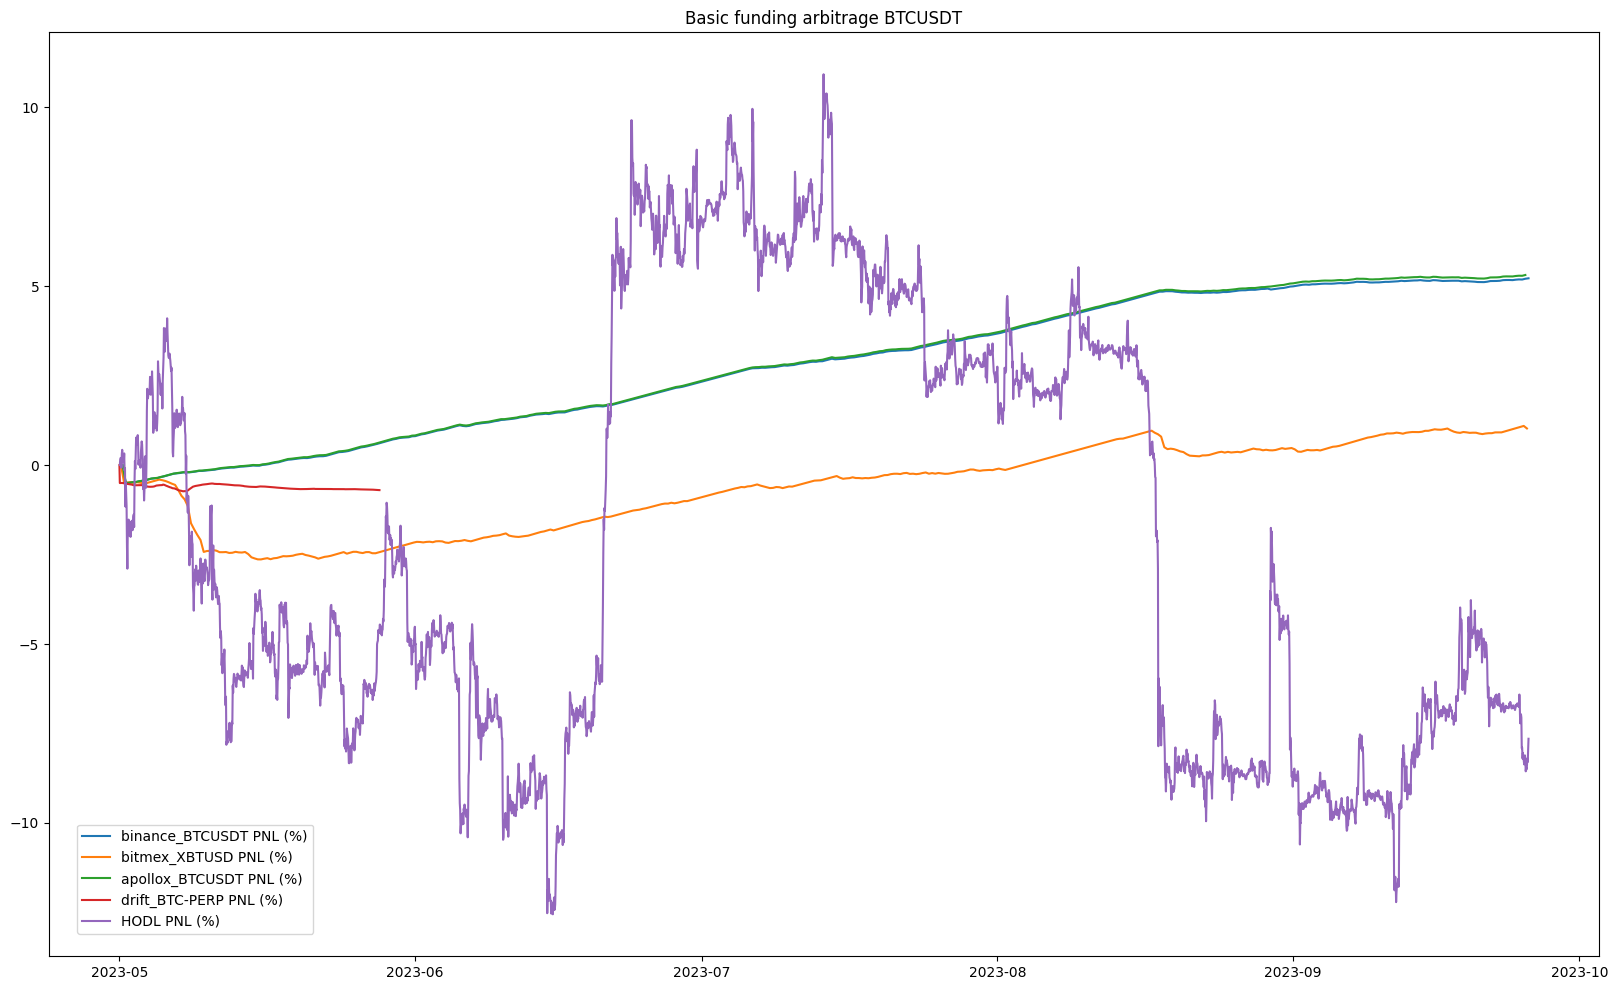

In [6]:
# Fetch and save funding rate history PNL 
from datetime import datetime

# Input
exchanges_market = {
    "binance": "BTCUSDT",
    "bitmex": "XBTUSD",
    "apollox": "BTCUSDT",
    "drift": "BTC-PERP"
}
benchmark_exchange = "binance"
benchmark_market = exchanges_market[benchmark_exchange]

# Initial variables
min_time = 0
max_time = datetime.now().timestamp()
funding_df_map = {}
price_df_map = {}
results = {}

leverage = 5

# Plot setup
fig, ax = plt.subplots(figsize=(20, 12))

# Fetch all funding rates and check date range
for exchange, market in exchanges_market.items():
    funding_df = fetcher.fetch_funding_rate_history_until_start(exchange, market)
    funding_df['datetime'] = funding_df['datetime'].dt.tz_localize(None)

    start_funding_time = funding_df['timestamp'].min()
    end_funding_time = funding_df['timestamp'].max()

    price_df = fetcher.fetch_ohlc(exchange, market, start_funding_time, end_funding_time)
    price_df['datetime'] = price_df['datetime'].dt.tz_localize(None)

    start_price_time = price_df['timestamp'].min()
    end_price_time = price_df['timestamp'].max()

    # Save result
    min_time = max(min_time, start_funding_time, start_price_time)
    max_time = min(max_time, end_funding_time, end_price_time)

    funding_df_map[exchange] = funding_df
    price_df_map[exchange] = price_df

min_datetime = pd.to_datetime(min_time, unit='s')
max_datetime = pd.to_datetime(max_time, unit='s')

# Fetch price data and calculate backtest result
for exchange, market in exchanges_market.items():
    funding_df = funding_df_map[exchange]
    price_df = price_df_map[exchange]

    funding_df = funding_df[(funding_df['datetime'] >= min_datetime) & (funding_df['datetime'] <= max_datetime)]
    price_df = price_df[(price_df['datetime'] >= min_datetime) & (price_df['datetime'] <= max_datetime)]

    input_df = pd.merge_asof(funding_df, price_df, on=['datetime'], tolerance=pd.Timedelta('1h'), direction='nearest')
    result_df = get_backtest_result(input_df, leverage)

    results[exchange] = result_df

# Plot and save result to file
for exchange, market in exchanges_market.items():
    result_df = results[exchange]
    ax.plot(result_df['datetime'], result_df['final_pnl'] * 100, label=f'{exchange}_{market} PNL (%)')
    result_df.to_csv(f'./data/{exchange}_{market}_{leverage}x.csv', index=False)

# Hodl result
price_df = price_df_map[benchmark_exchange]
price_df['datetime'] = price_df['datetime'].dt.tz_localize(None)
price_df = price_df[(price_df['datetime'] >= min_datetime) & (price_df['datetime'] <= max_datetime)]

hodl_df = get_hodl_result(price_df)
hodl_df['datetime'] = hodl_df['datetime'].dt.tz_localize(None)

ax.plot(hodl_df['datetime'], hodl_df['pnl'] * 100, label=f'HODL PNL (%)')
hodl_df.to_csv(f'./data/{benchmark_exchange}_{benchmark_market}_hodl.csv', index=False)

# Chart settings
lines, labels = ax.get_legend_handles_labels()
ax.set_title(f"Basic funding arbitrage {benchmark_market.split(':')[0]}")
ax.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.175, 0.15))

plt.show()

In [7]:
# Summary table

# Inputs
exchanges_markets = [
    {
        "binance": "BTCUSDT",
        "bitmex": "XBTUSD",
        "apollox": "BTCUSDT",
        "drift": "BTC-PERP"
    },
    {
        "binance": "ETHUSDT",
        "bitmex": "ETHUSD",
        "apollox": "ETHUSDT",
        "drift": "ETH-PERP"
    },
    {
        "binance": "SOLUSDT",
        "bitmex": "SOLUSD",
        "apollox": "SOLUSDT",
        "drift": "SOL-PERP"
    },
    {
        "binance": "XRPUSDT",
        "bitmex": "XRPUSD",
        "apollox": "XRPUSDT",
        "drift": "XRP-PERP"
    },
    {
        "binance": "BNBUSDT",
        "bitmex": "BNBUSD",
        "apollox": "BNBUSDT",
        "drift": "BNB-PERP"
    },
]

benchmark_exchange = "binance"

leverage = 1

result = []

for exchanges_market in exchanges_markets:
    market = exchanges_market[benchmark_exchange]
    hodl_df = pd.read_csv(f'./data/{benchmark_exchange}_{market}_hodl.csv')

    row = {}
    row['symbol'] = market
    row['exchange'] = 'hodl'
    row['pnl'] = hodl_df.iloc[-1]['pnl'] * 100
    row['max_drawdown'] = max_drawdown(hodl_df['pnl']) * 100
    row['corr'] = hodl_df['pnl'].corr(hodl_df['pnl'])
    result.append(row)

    for exchange, market in exchanges_market.items():

        data_df = pd.read_csv(f'./data/{exchange}_{market}_{leverage}x.csv')

        row = {}
        row['symbol'] = market
        row['exchange'] = exchange
        row['pnl'] = data_df.iloc[-1]['final_pnl'] * 100
        row['max_drawdown'] = max_drawdown(data_df['final_pnl']) * 100
        row['corr'] = data_df['final_pnl'].corr(hodl_df['pnl'])

        result.append(row)

result_df = pd.DataFrame(result)
result_df.to_csv("./output/basic_funding.csv")

In [75]:
# Leveraged funding arbitrage

# Fetch and save funding rate history PNL 
from datetime import datetime, timedelta

# Input
min_time = datetime.now() - timedelta(days=365 * 2)
max_time = datetime.now()
exchange = 'bitmex'
market = 'XRPUSD'

# Initial variables
funding_df_map = {}
price_df_map = {}
results = {}

max_leverage = 10

# Fetch data
funding_df = fetcher.fetch_funding_rate_history_until_start(exchange, market)
funding_df['datetime'] = funding_df['datetime'].dt.tz_localize(None)
funding_df = funding_df[(funding_df['datetime'] >= min_time) & (funding_df['datetime'] <= max_time)]

price_df = fetcher.fetch_ohlc(exchange, market, funding_df['timestamp'].min(), funding_df['timestamp'].max())
price_df['datetime'] = price_df['datetime'].dt.tz_localize(None)

funding_df = funding_df[(funding_df['datetime'] >= price_df['datetime'].min()) & (funding_df['datetime'] <= price_df['datetime'].max())]

input_df = pd.merge_asof(funding_df, price_df, on=['datetime'], tolerance=pd.Timedelta('1h'), direction='nearest')

input_df['open'] = input_df['open'].fillna(method='ffill')
input_df['high'] = input_df['high'].fillna(method='ffill')
input_df['low'] = input_df['low'].fillna(method='ffill')
input_df['close'] = input_df['close'].fillna(method='ffill')

# Fetch price data and calculate backtest result and save result to file
for leverage in range(1, max_leverage + 1):
    result_df = get_backtest_result(input_df, leverage)
    results[leverage] = result_df
    result_df.to_csv(f'./data/{exchange}_{market}_{leverage}x.csv', index=False)

# Hodl result
hodl_df = get_hodl_result(input_df)
hodl_df['datetime'] = hodl_df['datetime'].dt.tz_localize(None)
hodl_df.to_csv(f'./data/{exchange}_{market}_hodl.csv', index=False)

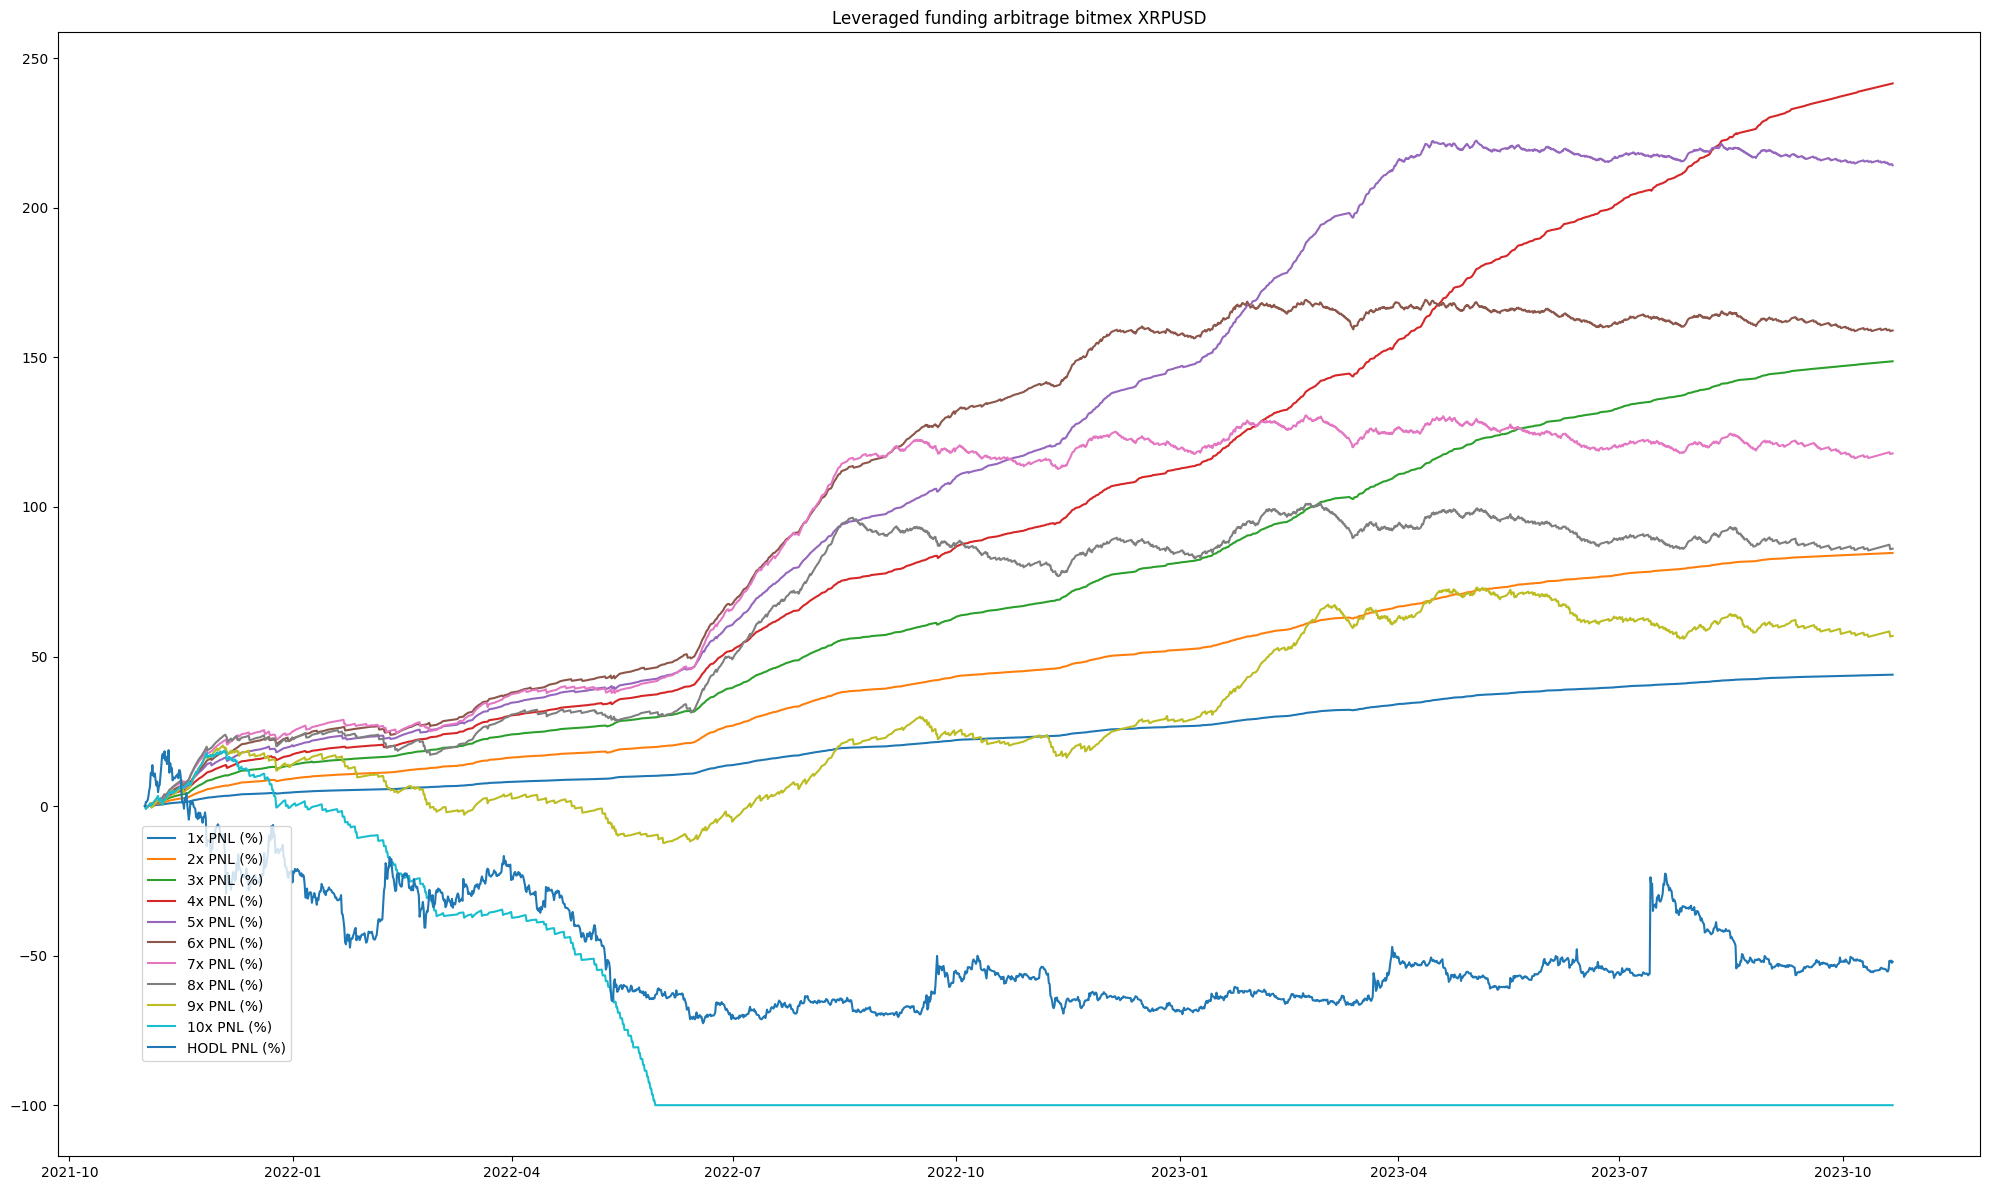

In [76]:
# Plot leveraged funding arbitrage result

# Plot setup
fig, ax = plt.subplots(figsize=(20, 12))
# Plot
for leverage in range(1, max_leverage + 1):
    result_df = results[leverage]
    ax.plot(result_df['datetime'], result_df['final_pnl'] * 100, label=f'{leverage}x PNL (%)')

ax.plot(hodl_df['datetime'], hodl_df['pnl'] * 100, label=f'HODL PNL (%)')

# Chart settings
lines, labels = ax.get_legend_handles_labels()
ax.set_title(f"Leveraged funding arbitrage {exchange} {market}")
ax.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.125, 0.3))

plt.tight_layout()
plt.savefig(f'./images/leveraged_{exchange}_{market}.png', dpi=300, format='png')
plt.show()

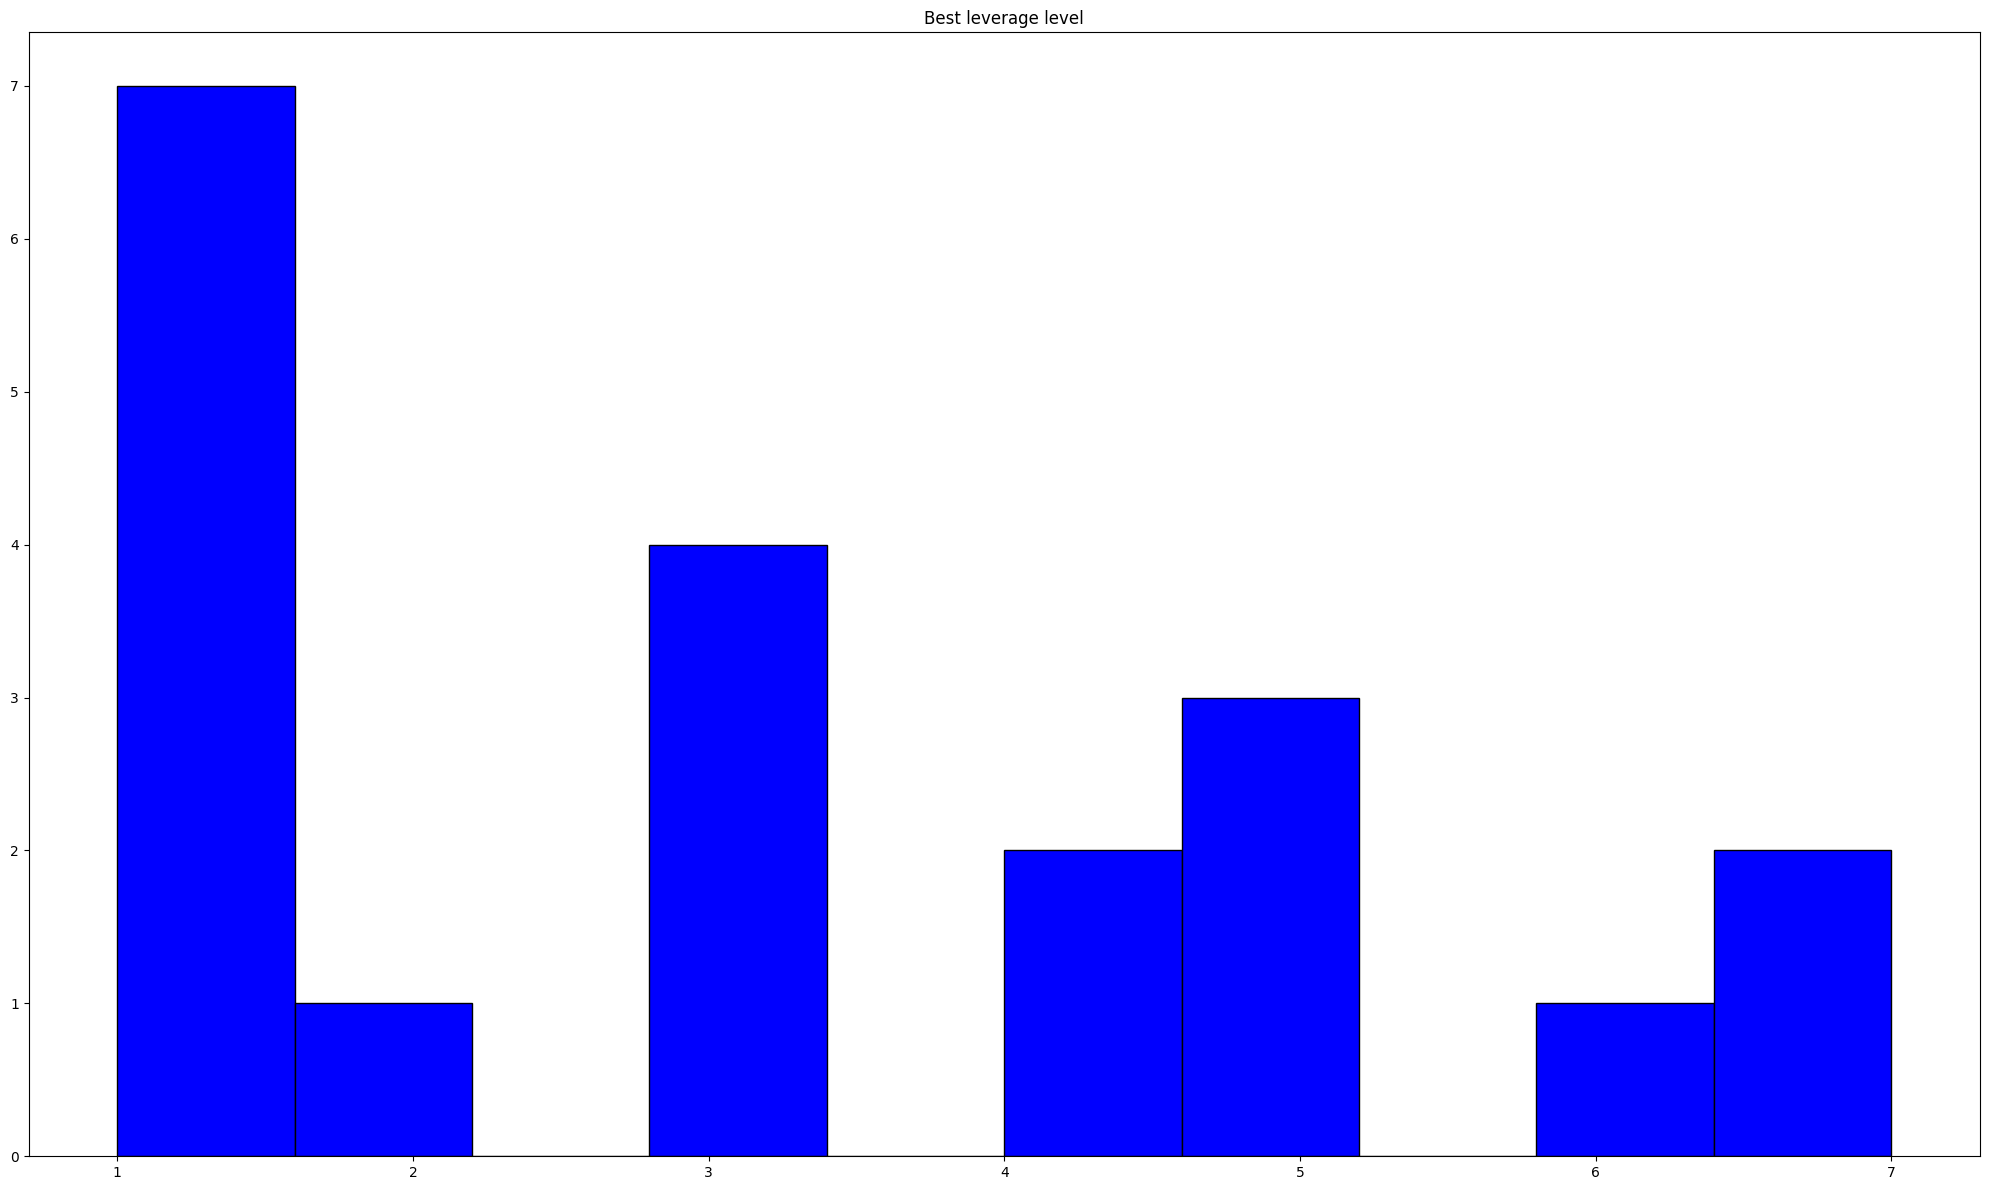

In [80]:
# Plot histogram showing which leverage level is the best
from matplotlib.ticker import MultipleLocator

# Inputs
exchanges_markets = [
    {
        "binance": "BTCUSDT",
        "bitmex": "XBTUSD",
        "apollox": "BTCUSDT",
        "drift": "BTC-PERP"
    },
    {
        "binance": "ETHUSDT",
        "bitmex": "ETHUSD",
        "apollox": "ETHUSDT",
        "drift": "ETH-PERP"
    },
    {
        "binance": "SOLUSDT",
        "bitmex": "SOLUSD",
        "apollox": "SOLUSDT",
        "drift": "SOL-PERP"
    },
    {
        "binance": "XRPUSDT",
        "bitmex": "XRPUSD",
        "apollox": "XRPUSDT",
        "drift": "XRP-PERP"
    },
    {
        "binance": "BNBUSDT",
        "bitmex": "BNBUSD",
        "apollox": "BNBUSDT",
        "drift": "BNB-PERP"
    },
]

best_leverages = []


# Calculation
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        best_leverage = 1
        max_pnl = 0
        for leverage in range(1, max_leverage + 1):
            result_df = pd.read_csv(f'./data/{exchange}_{market}_{leverage}x.csv')
            pnl = result_df.iloc[-1]['final_pnl']
            if pnl > max_pnl:
                max_pnl = pnl
                best_leverage = leverage

        num_date = len(pd.date_range(result_df['datetime'].min(), result_df['datetime'].max(), freq='D'))  
        apy = 365 / num_date * max_pnl
        best_leverages.append({
            "exchange": exchange,
            "market": market,
            "leverage": best_leverage,
            "num_date": num_date,
            "pnl": max_pnl,
            "apy": apy
        })

df = pd.DataFrame(best_leverages)
df.to_csv("./output/best_leverages.csv")

# Plot setup
fig, ax = plt.subplots(figsize=(20, 12))

plt.hist(df['leverage'], color='blue', edgecolor='black')    

# Chart settings
ax.set_title(f"Best leverage level")
ax.xaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()
# plt.savefig(f'./images/leveraged_{exchange}_{market}.png', dpi=300, format='png')
plt.show()